# Car Purchase Amount — Regression Model Comparison

This notebook loads **Car_Purchasing_Data.csv**, cleans it, and compares three regression models: **Linear Regression**, **Random Forest**, and **XGBoost**. It evaluates using **RMSE** and **R²**, shows a prediction vs actual plot for the best model, and saves the best model to disk.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Try importing XGBoost; if not available, install instruction printed
try:
    from xgboost import XGBRegressor
except Exception as e:
    XGBRegressor = None
    print('XGBoost not available in this environment. If you want XGBoost, run `pip install xgboost`.')


In [2]:
# Load dataset (ensure Car_Purchasing_Data.csv is uploaded to the runtime)
df = pd.read_csv('Car_Purchasing_Data.csv')
print('Shape:', df.shape)
df.head()


Shape: (500, 9)


,Customer Name,Customer e-mail,Country,Gender,Age,Annual Salary,Credit Card Debt,Net Worth,Car Purchase Amount
0,Martina Avila,cubilia.Curae.Phasellus@quisaccumsanconvallis.edu,USA,0,42,62812.09301,11609.380910,238961.2505,35321.45877
1,Harlan Barnes,eu.dolor@diam.co.uk,USA,0,41,66646.89292,9572.957136,530973.9078,45115.52566
2,Naomi Rodriquez,vulputate.mauris.sagittis@ametconsectetueradip...,USA,1,43,53798.55112,11160.355060,638467.1773,42925.70921
3,Jade Cunningham,malesuada@dignissim.com,USA,1,58,79370.03798,14426.164850,548599.0524,67422.36313
4,Cedric Leach,felis.ullamcorper.viverra@egetmollislectus.net,USA,1,57,59729.15130,5358.712177,560304.0671,55915.46248


In [3]:
# Basic cleaning and target selection
df = df.copy()
# Drop obvious non-predictive columns if present
for col in ['Customer Name', 'Customer e-mail']:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

TARGET = 'Car Purchase Amount'
if TARGET not in df.columns:
    raise ValueError(f"Target column '{TARGET}' not found in the dataset. Available columns: {list(df.columns)}")

X = df.drop(columns=[TARGET])
y = df[TARGET]

print('Features:', X.columns.tolist())


Features: ['Country', 'Gender', 'Age', 'Annual Salary', 'Credit Card Debt', 'Net Worth']


In [4]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)


Train shape: (400, 6) Test shape: (100, 6)


In [6]:
# Prepare preprocessing pipelines
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category','bool']).columns.tolist()

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])
print('Numeric columns:', num_cols)
print('Categorical columns:', cat_cols)


Numeric columns: ['Gender', 'Age', 'Annual Salary', 'Credit Card Debt', 'Net Worth']
Categorical columns: ['Country']


In [21]:
# Define models to compare
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}
if XGBRegressor is not None:
    models['XGBoost'] = XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42)

results = {}

for name, model in models.items():
    pipe = Pipeline([('pre', preprocessor), ('model', model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    results[name] = {'RMSE': float(rmse), 'R2': float(r2)}
    print(f"\nModel: {name}\n  RMSE: {rmse:.4f}\n  R2: {r2:.4f}")



Model: Linear Regression
  RMSE: 249.5074
  R2: 0.9994

Model: Random Forest
  RMSE: 2281.0434
  R2: 0.9518

Model: XGBoost
  RMSE: 2153.3531
  R2: 0.9571


In [22]:
# Summary table
results_df = pd.DataFrame(results).T.sort_values(by='RMSE')
results_df


,RMSE,R2
Linear Regression,249.507447,0.999423
XGBoost,2153.353061,0.957055
Random Forest,2281.043399,0.951811


In [23]:
# Pick best model (lowest RMSE), retrain on full data, and save
best_name = results_df.index[0]
print('Best model:', best_name)
best_model = models[best_name]
final_pipeline = Pipeline([('pre', preprocessor), ('model', best_model)])
final_pipeline.fit(X, y)
out_name = f'best_model_{best_name.replace(" ","_")}.joblib'
joblib.dump(final_pipeline, out_name)
print('Saved:', out_name)


Best model: Linear Regression
Saved: best_model_Linear_Regression.joblib


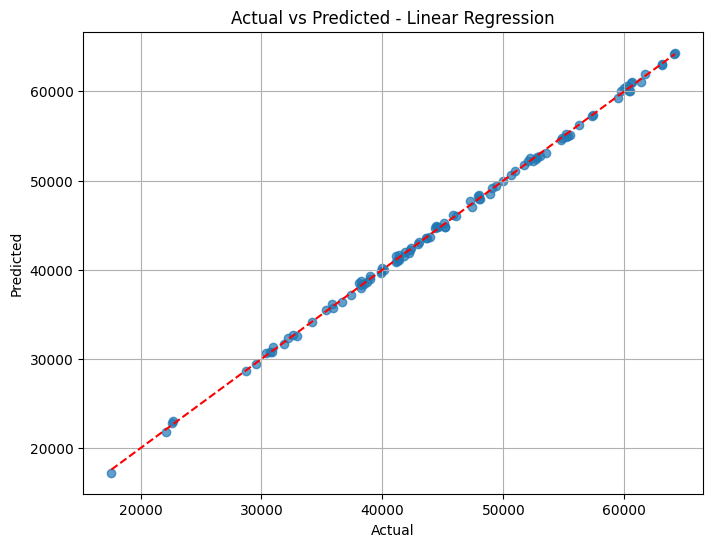

In [24]:
# Plot predictions vs actual for the best model on test set
best_pipe = Pipeline([('pre', preprocessor), ('model', models[best_name])])
best_pipe.fit(X_train, y_train)
preds_test = best_pipe.predict(X_test)

plt.figure(figsize=(8,6))
plt.scatter(y_test, preds_test, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Actual vs Predicted - {best_name}')
plt.grid(True)
plt.show()
